In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import hdbscan

### create dataframes koumura

In [4]:
DATASET_ID = 'koumura_bengalese_finch'
embeddings_dfs = list(DATA_DIR.glob('embeddings/'+DATASET_ID+'/*.pickle'))
DATASET_ID = 'bengalese_finch_sober'
embeddings_dfs = embeddings_dfs + list(DATA_DIR.glob('embeddings/'+DATASET_ID+'/*.pickle'))

#embeddings_dfs = list(DATA_DIR.glob('embeddings/'+DATASET_ID+'/*.pickle'))

Bird0


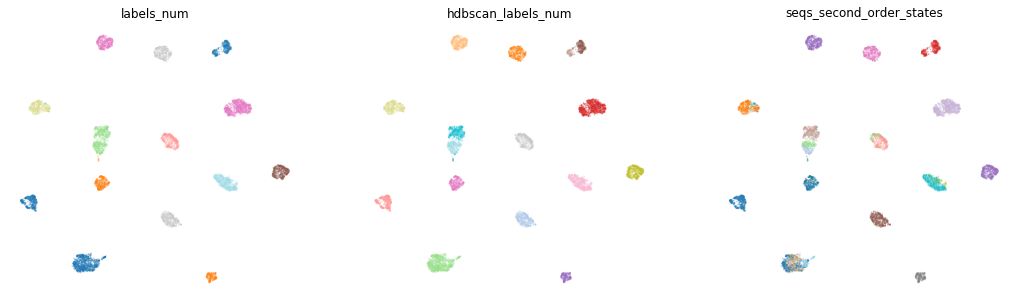

Bird2


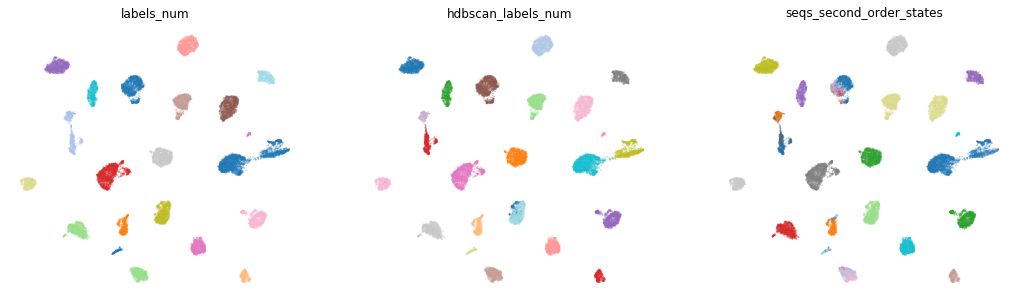

Bird9


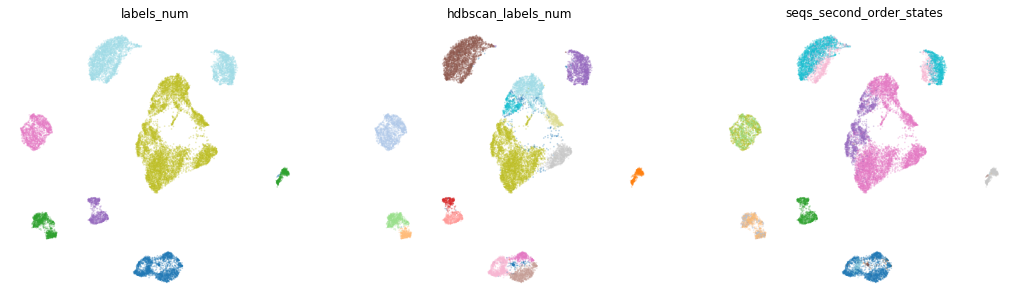

Bird4


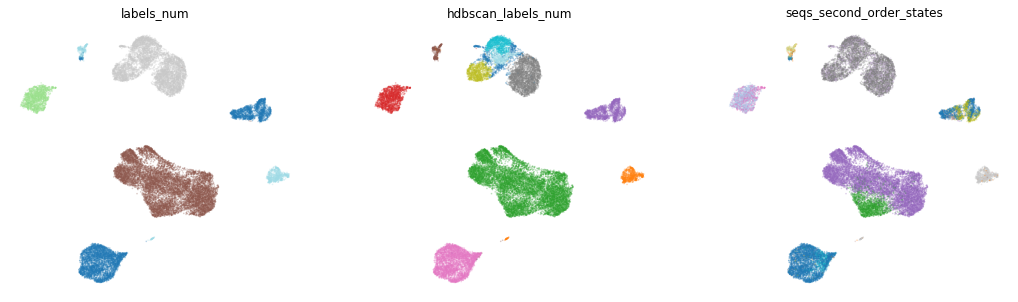

Bird6


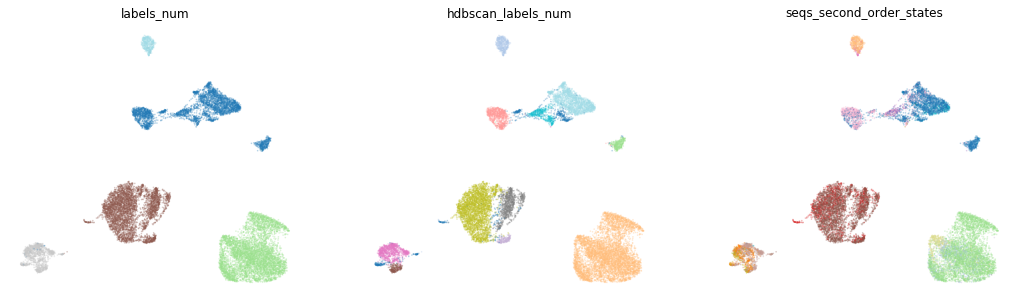

Bird10


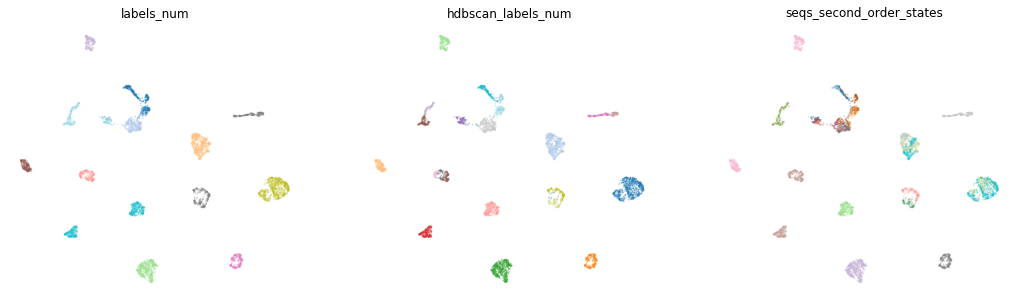

Bird5


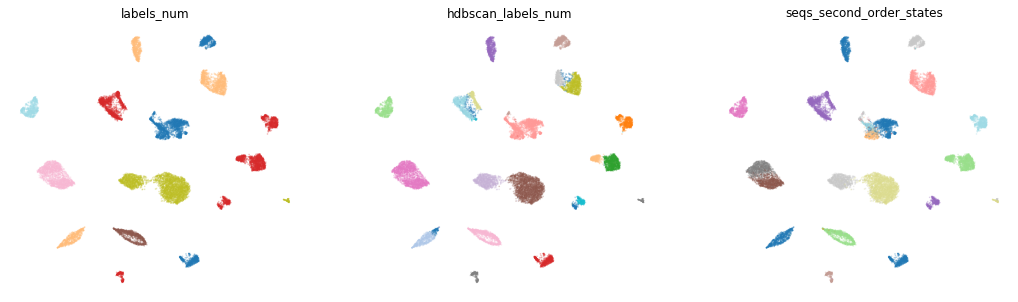

Bird8


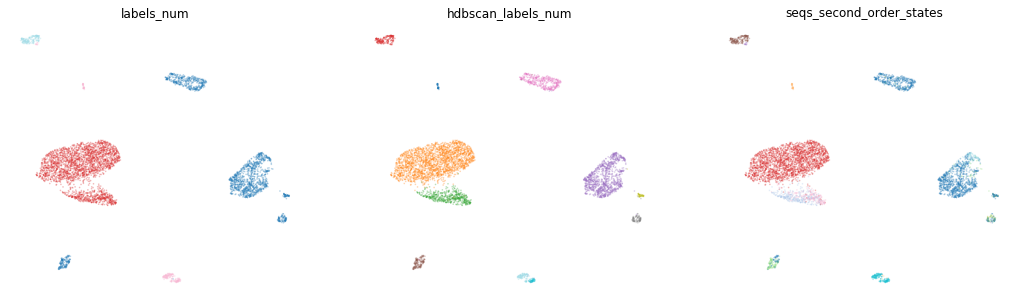

Bird7


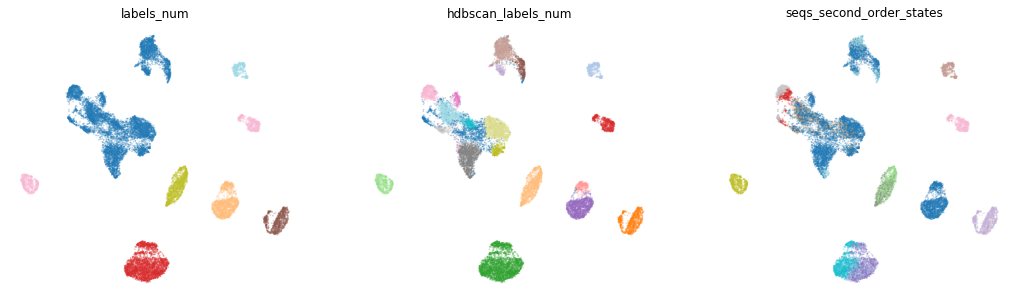

Bird1


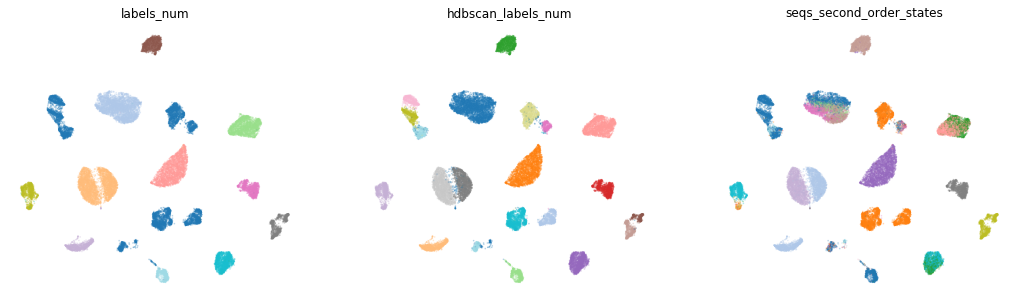

Bird3


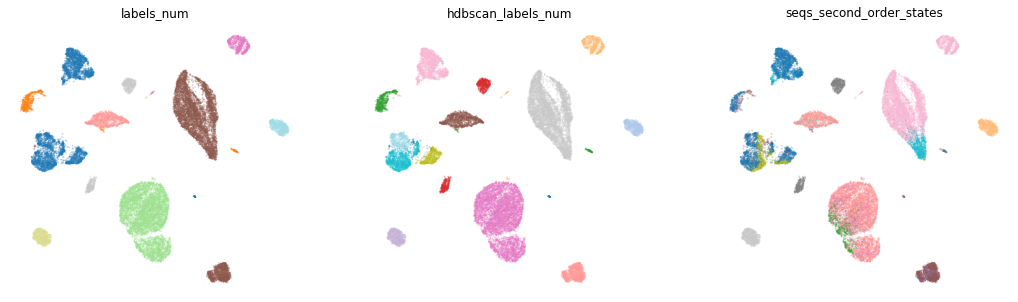

or60yw70


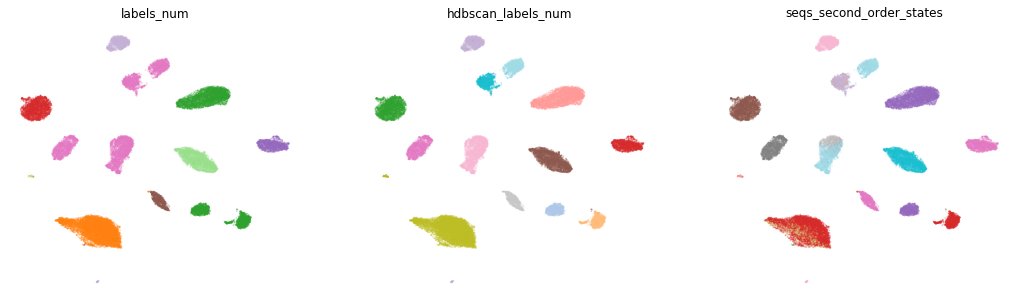

gy6or6


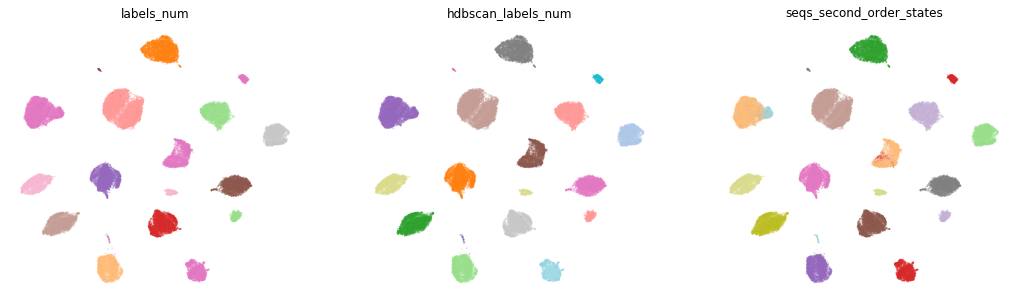

gr41rd51


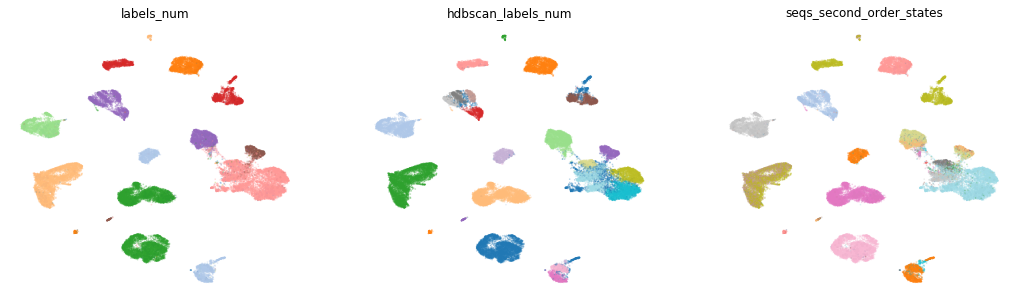

bl26lb16


In [ ]:
# loop through, label, save
for loc in tqdm(embeddings_dfs):
    DATASET_ID = loc.parent.stem
    # read dataframe
    indv_df = pd.read_pickle(loc).sort_values(by=["key", "start_time"])
    indv = indv_df.indv.unique()[0]
    print(indv)

    # project
    specs_flattened = flatten_spectrograms(list(indv_df.spectrogram.values))
    fit = cumlUMAP(min_dist=0.1)
    z = np.vstack(list(fit.fit_transform(specs_flattened)))
    indv_df["umap-0.1"] = list(z)
    
    fit = cumlUMAP(min_dist=0.25)
    z = np.vstack(list(fit.fit_transform(specs_flattened)))
    indv_df["umap-0.25"] = list(z)
    
    # get sequence and order
    syllables_sequence_pos = np.concatenate(
        [
            np.arange(np.sum(indv_df.key == key))
            for key in indv_df.key.unique()
        ]
    )
    syllables_sequence_id = np.concatenate(
        [
            np.repeat(ki, np.sum(indv_df.key == key))
            for ki, key in enumerate(indv_df.key.unique())
        ]
    )
    indv_df["syllables_sequence_pos"] = syllables_sequence_pos
    indv_df["syllables_sequence_id"] = syllables_sequence_id
    
    # convert labels to integers
    label_dict = {lab:i for i, lab in enumerate(np.unique(indv_df['labels'].values))}
    indv_df['labels_num'] = [label_dict[i] for i in indv_df.labels.values]
    indv_df['labels_num'].unique()
    
    # cluster labels
    for min_dist in ["", "-0.1", "-0.25"]:
        z = np.vstack(indv_df["umap" + min_dist].values)
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=int(len(z) * 0.01), # the smallest size we would expect a cluster to be
            min_samples=1, # larger values = more conservative clustering
        ).fit(z)
        indv_df['hdbscan_labels'+min_dist] = clusterer.labels_

    for hdbscan_to_use in ['hdbscan_labels', 'hdbscan_labels-0.1', 'hdbscan_labels-0.25']:
    
        unique_states = np.unique(indv_df[hdbscan_to_use])
        lab_dict = {lab: i for i, lab in enumerate(unique_states)}

        # convert seqs to numbers
        indv_df[hdbscan_to_use + '_num'] = [lab_dict[i] for i in indv_df[hdbscan_to_use].values]
    
    ### label by second order 
    # sequences
    seqs = [
        list(indv_df[indv_df.syllables_sequence_id == seqid]["labels_num"].values)
        for seqid in indv_df.syllables_sequence_id.unique()
    ]

    # get second order states
    seqs_second_order = [
        [
            str(seq[i - 1]) + "-" + str(element)
            if i > 0
            else str("start") + "-" + str(element)
            for i, element in enumerate(seq)
        ]
        for seq in seqs
    ]
    unique_second_order_labels = np.unique(np.concatenate(seqs_second_order))
    # convert to numbers
    state_conversion_dict = {state: num for num, state in enumerate(unique_second_order_labels)}
    #seqs_second_order_states = [['None-start'] + [state_conversion_dict[i] for i in seq] + ['None-end'] for seq in seqs_second_order]
    seqs_second_order_states = [[state_conversion_dict[i] for i in seq]  for seq in seqs_second_order]
    indv_df['seqs_second_order'] = np.concatenate(seqs_second_order)
    indv_df['seqs_second_order_states'] = np.concatenate(seqs_second_order_states)
    
    lab_list = ['labels_num', 'hdbscan_labels_num', 'seqs_second_order_states']
    fig, axs = plt.subplots(ncols=len(lab_list), figsize=(6*len(lab_list),5))
    for i, lab in enumerate(lab_list):
        ax = axs[i]
        ax.scatter(z[:,0], z[:,1], c = indv_df[lab], s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
        ax.axis('off')
        ax.set_title(lab)
    plt.show()
    
    # save dataframe
    save_loc = DATA_DIR / 'bf_label_dfs' / DATASET_ID / (indv + '.pickle')
    ensure_dir(save_loc)
    indv_df.to_pickle(save_loc)
    #break

In [ ]:
indv_df[:3]